In [425]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [426]:
#estado 0 -> C U P, 1 -> C U ~P, 2 -> ~C U P, 3 -> ~C U ~P.
class barraca_de_peixe_fresco:
    def __init__(self):

        self.capital_inicial = 500
        self.S = 500
        self.menor_capital = 500

        self.Clientes_n_atendidos = 0
        self.Clientes = 0
        self.n_clientes = 0

        self.num_descansos = 0
        self.horas_entre_descanso = 0 #guarda o número de horas que não são de descanso

        self.pesca_relaxada = False
        self.Peixe = 0
        self.p = 0.4
        self.q = 0.7

        #caso o modo preguiçoso seja ativado o preço ideal fica ~32.2
        #pois a probabilidade de estarmos no estado 0 vai para ~30%.
        #self.Venda_peixe = 32 #modo não preguiçoso.
        self.Venda_peixe = 32.2
        self.Preco_barraca = 10
        self.Renda = []
        self.Fluxo_clientes = []

        self.p_0 = 0
        self.p_1 = 0
        self.p_2 = 0
        self.p_3 = 0

        self.flag = False

    def pescar(self):
        pegar_peixe = np.random.random()
        if pegar_peixe <= self.q:
            self.Peixe = 1

    def cozinhar(self):

        self.vender_peixe()
        self.Peixe = 0

    def descansar(self):
        pass

    def pagar_barraca(self):
        self.S -= self.Preco_barraca
        if(self.S < self.menor_capital):
            self.menor_capital = self.S

    def vender_peixe(self):
        self.S += self.Venda_peixe
        self.Clientes = 0

    def proxima_acao(self):
        probab_novo_cliente = np.random.random()

        #'''
        if(self.pesca_relaxada == False and self.S > self.capital_inicial):
            self.pesca_relaxada = True
            self.q *= 0.8
            
        elif(self.S <= self.capital_inicial and self.pesca_relaxada == True):
            self.pesca_relaxada = False
            self.q /= 0.8
        #'''
        if (self.Clientes == 1 and probab_novo_cliente <= self.p):
                self.Clientes_n_atendidos += 1
                
        if probab_novo_cliente <= self.p:
            self.n_clientes += 1
            self.Clientes = 1
            
        if(probab_novo_cliente <= self.p or self.Clientes == 1):

            if self.Peixe == 0:
                self.p_1 += 1
                if(self.num_descansos >= 1):
                    self.horas_entre_descanso += 1
                self.pescar()
            else:
                self.p_0 +=1
                self.Clientes = 0
                if(self.num_descansos >= 1):
                    self.horas_entre_descanso += 1
                self.cozinhar()

        else:
            if self.Peixe == 0:
                self.p_3 += 1
                if(self.num_descansos >= 1):
                    self.horas_entre_descanso += 1
                self.pescar()

            else:
                self.p_2 += 1
                self.num_descansos += 1
                self.descansar()

        self.pagar_barraca()

        self.Fluxo_clientes.append(self.Clientes)
        self.Renda.append(self.S)


In [431]:
barraca = barraca_de_peixe_fresco()
num_horas = 900
num_barracas = 500
num_falencias = 0

clientes_totais = 0
clientes_n_atendidos_totais = 0

media_capital_final = 0
menor_cap_sem_fal = 0
menor_cap = 0

media_entre_descansos = 0 

prob_0 = 0
prob_1 = 0
prob_2 = 0
prob_3 = 0

file = open('example.csv', 'w')
writer = csv.writer(file)

l = np.arange(num_barracas)

for k in l:
    t = np.arange(num_horas)
    for i in t:
        barraca.proxima_acao()
        if (barraca.flag == False and barraca.S < 0):
            barraca.flag = True
            num_falencias += 1
    
    
    #extrair as variáveis de interesse para a barraca atual:
    prob_0 += barraca.p_0
    prob_1 += barraca.p_1
    prob_2 += barraca.p_2
    prob_3 += barraca.p_3

    
    clientes_totais += barraca.n_clientes
    clientes_n_atendidos_totais += barraca.Clientes_n_atendidos

    if(barraca.flag == False):
        media_capital_final += barraca.S
        menor_cap_sem_fal += barraca.menor_capital

    menor_cap += barraca.menor_capital
    media_entre_descansos += (barraca.horas_entre_descanso/(barraca.num_descansos-1))

    writer.writerow(barraca.Renda)
    #não sei muito bem o que é pra escrever no csv, quais gráficos são mais interessantes, 
    #etc, tava só testando

    barraca = barraca_de_peixe_fresco()

prob_0 /= (num_barracas*num_horas)
prob_1 /= (num_barracas*num_horas)
prob_2 /= (num_barracas*num_horas)
prob_3 /= (num_barracas*num_horas)

media_n_atendidos = (clientes_n_atendidos_totais/num_barracas)

media_capital_final /= num_barracas
menor_cap_sem_fal /= num_barracas
menor_cap /= num_barracas
media_preco = 10/prob_0

media_entre_descansos /= num_barracas

#no modo preguiçoso a media dos preços não faz sentido calculada
#da forma que está, pois o preço influencia no tempo que o pescador
#fica com o capital > inicial, que influencia na probabilidade de ir
#para o estágio 0, que por sua vez influencia no preço (...)
#se alguém conseguir explicar/encontrar a expressão para a o cálculo do preço
#ótimo, mas talvez seja necessário ver com o monitor. empiricamente o preço é ~32.1-32.2

print(f'media dos precos total: {media_preco}')
print(f'clientes totais: {clientes_totais}')
print(f'clientes não atendidos totais: {clientes_n_atendidos_totais}')
print(f'média de não atendidos por barraca: {media_n_atendidos:.3f}')
print(f'probabilidade de um cliente não ser atendido: {(clientes_n_atendidos_totais/(clientes_totais)):.3f}')
print(f'num falencias: {num_falencias}')
print(f'prob de falencia: {(num_falencias/num_barracas):.3f}')
print(f'dado que não houve falência, valor esperado do capital final: {media_capital_final:.3f}')
print(f'média do menor capital sem falências: {menor_cap_sem_fal:.3f}')
print(f'média do menor capital com falências: {menor_cap:.3f}')
print(f'media de horas entre cada descanso:{media_entre_descansos:.3f} ')
print(f'probabilidade de estar em cada um dos estados:\n0:{prob_0:f}\n3:{prob_1:f}\n2:{prob_2:f}\n3:{prob_3:f}')
print(f'{prob_0+prob_1+prob_2+prob_3}')
file.close()

media dos precos total: 32.70610295881212
clientes totais: 180138
clientes não atendidos totais: 42427
média de não atendidos por barraca: 84.854
probabilidade de um cliente não ser atendido: 0.236
num falencias: 40
prob de falencia: 0.080
dado que não houve falência, valor esperado do capital final: 358.285
média do menor capital sem falências: 225.793
média do menor capital com falências: 217.177
media de horas entre cada descanso:3.465 
probabilidade de estar em cada um dos estados:
0:0.305753
3:0.235700
2:0.226811
3:0.231736
1.0


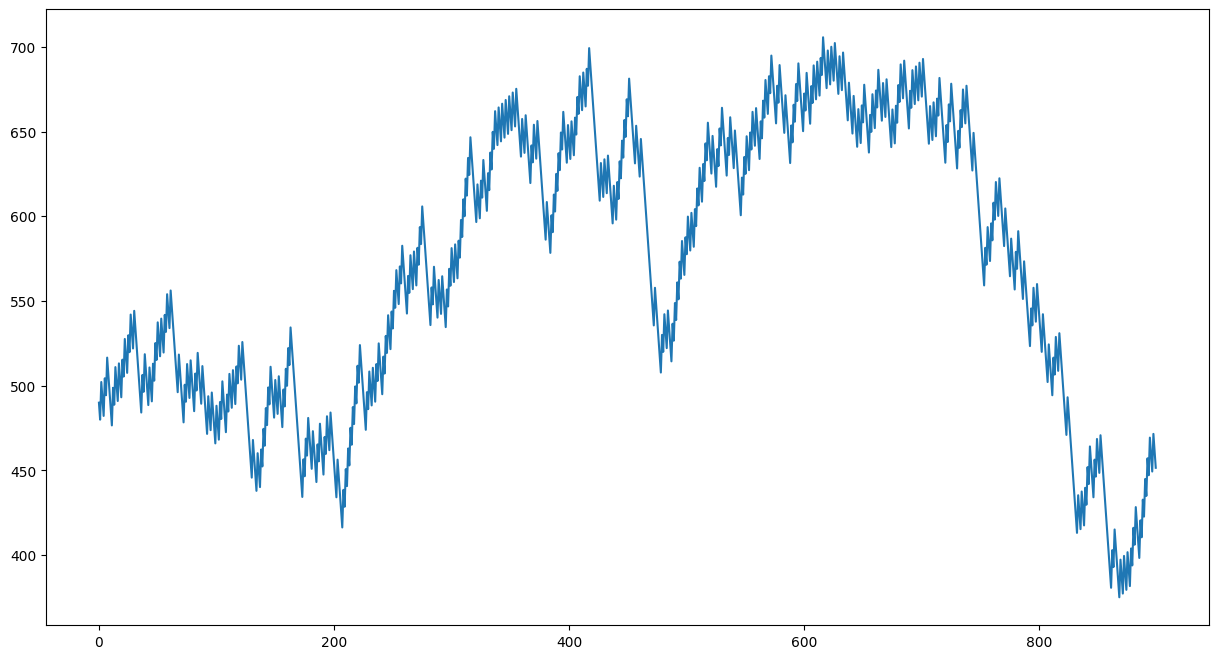

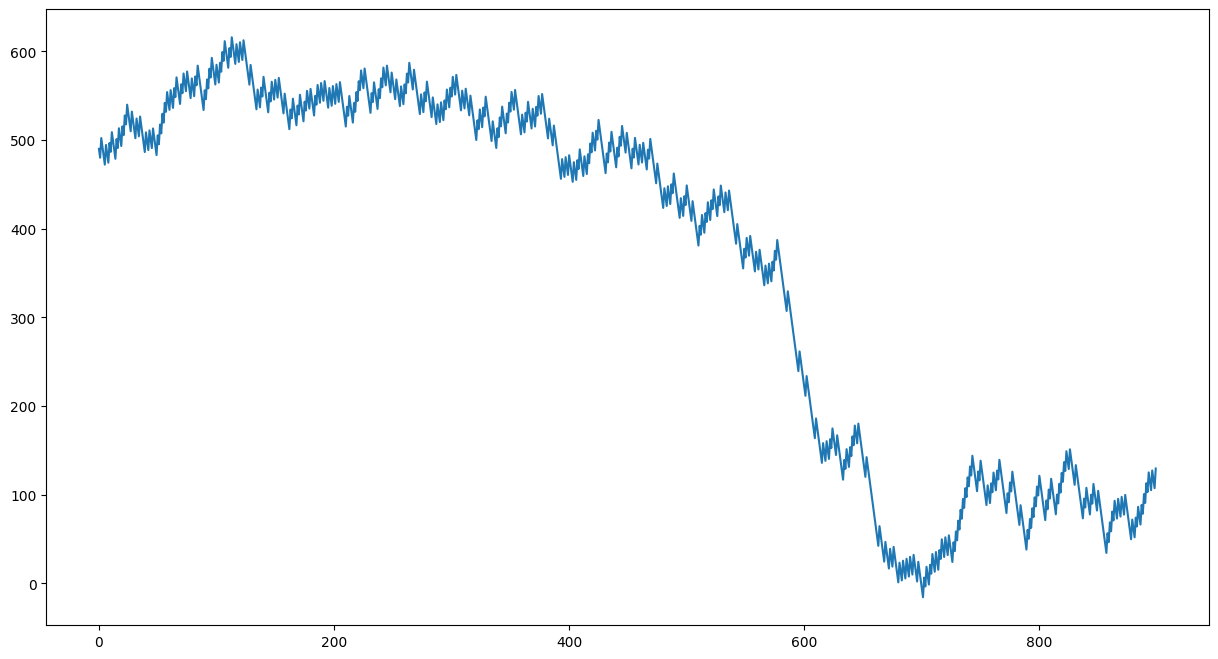

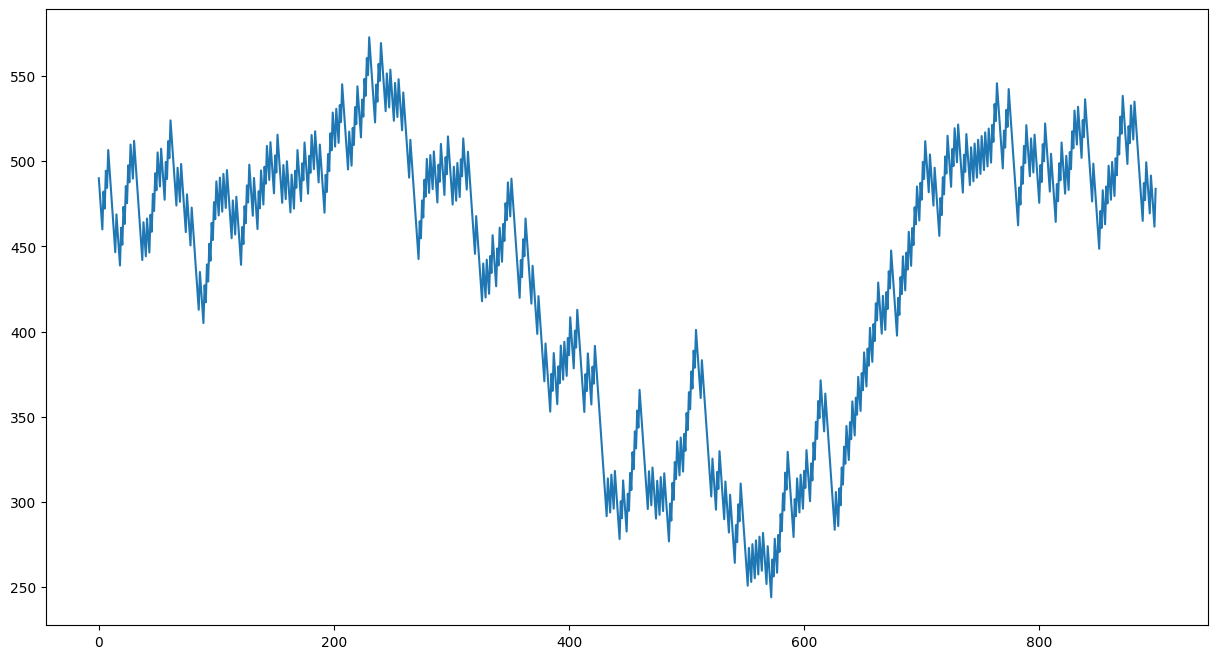

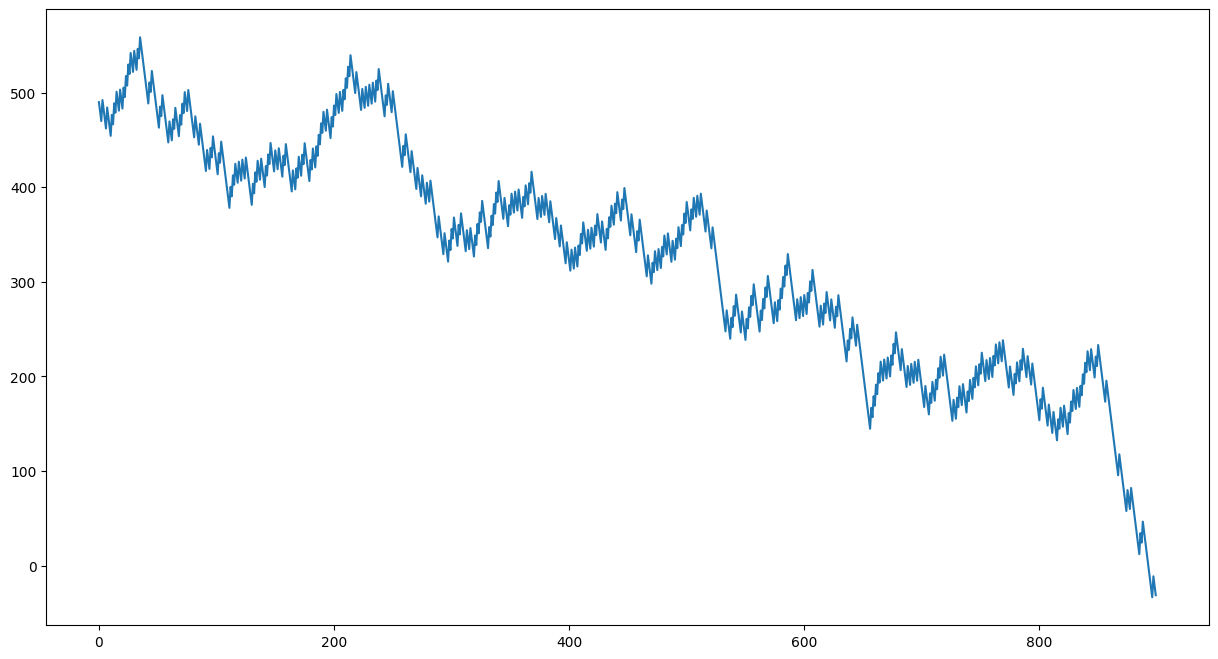

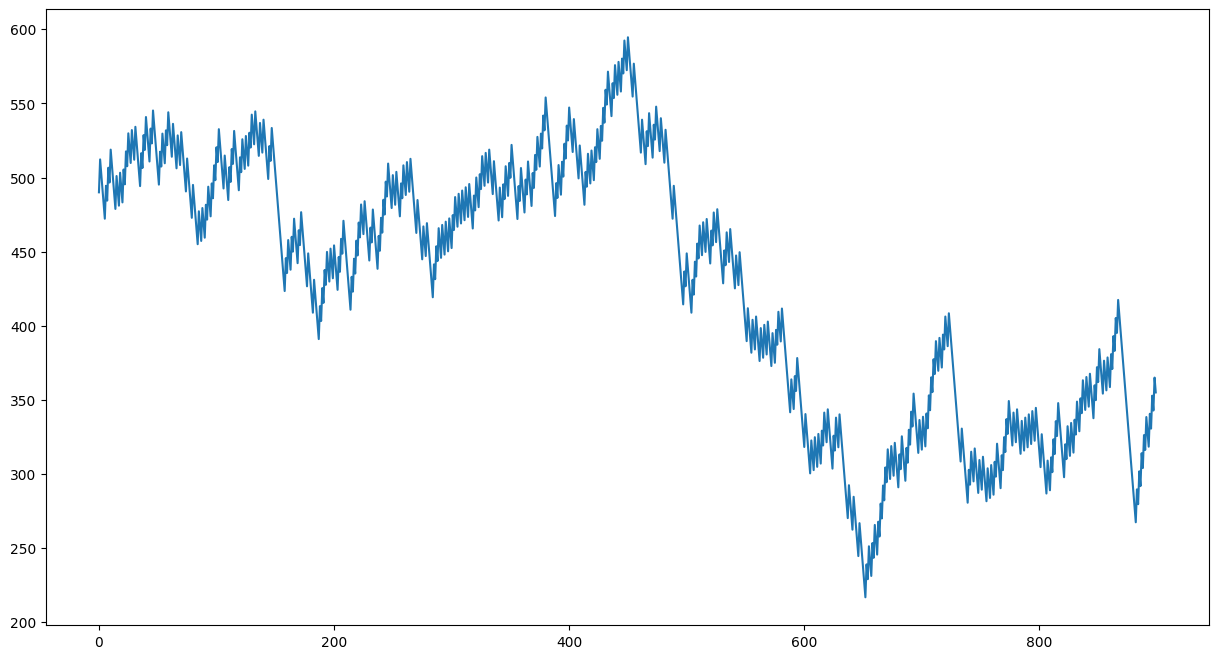

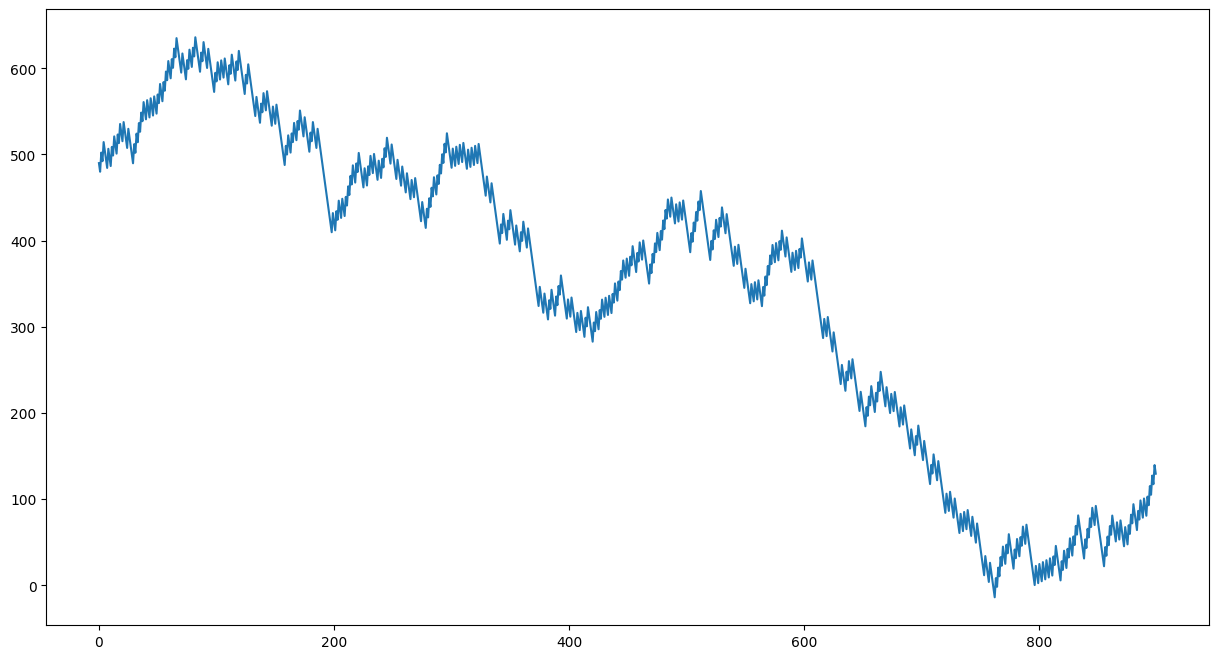

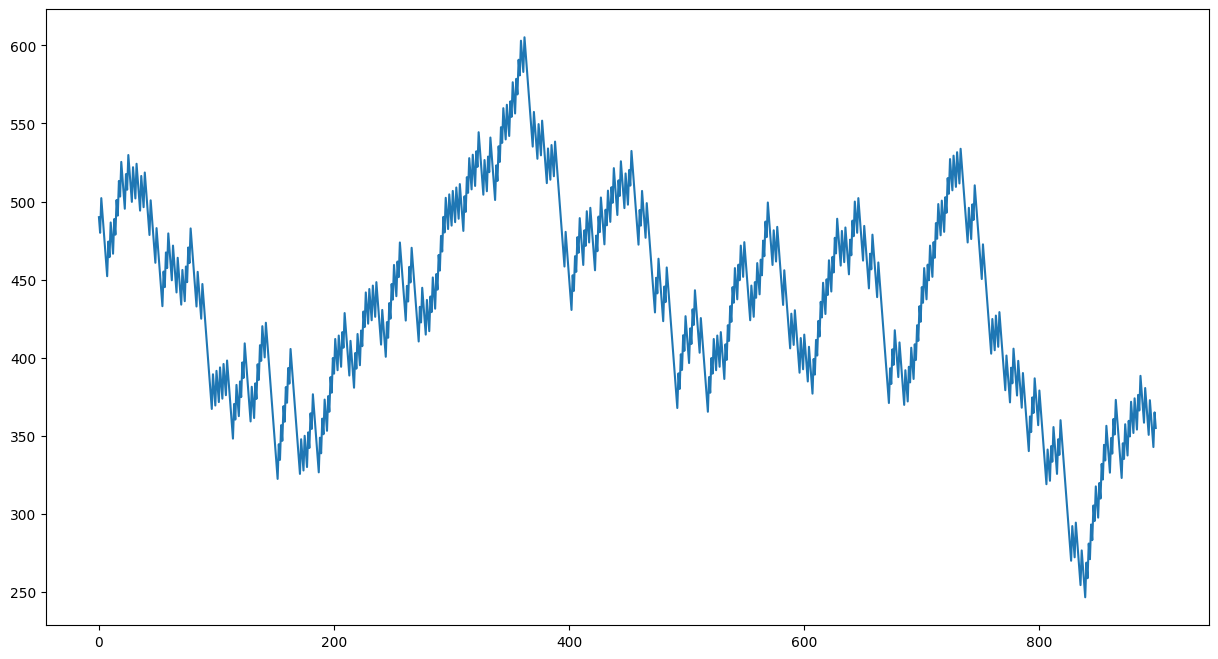

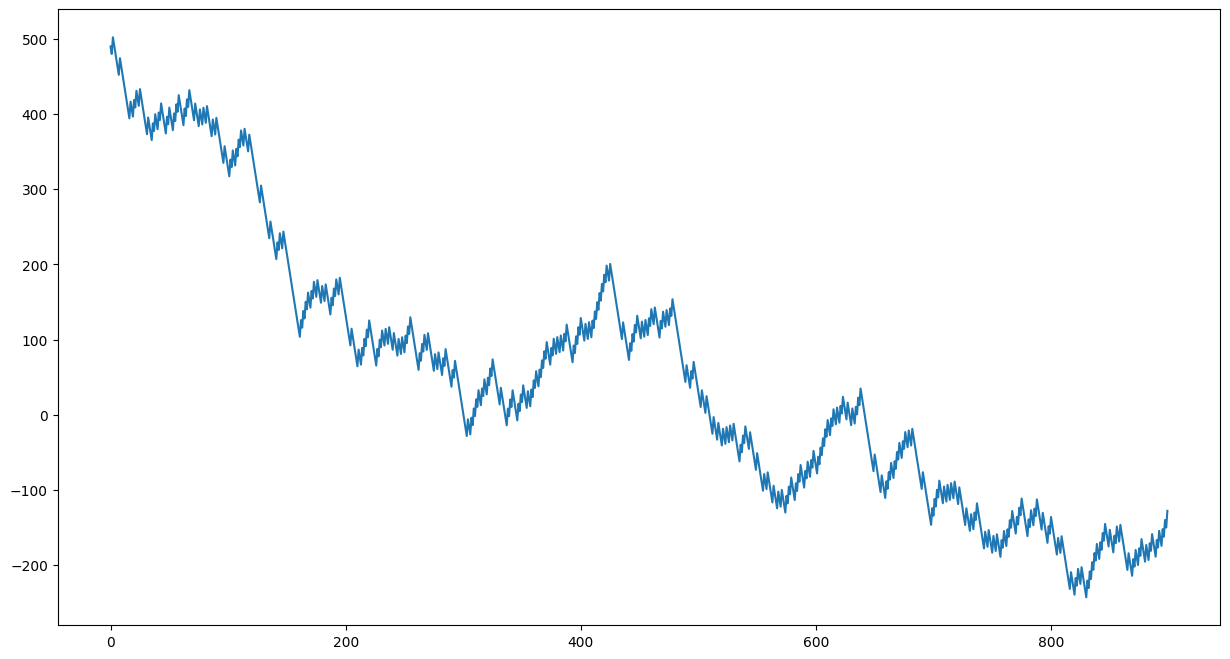

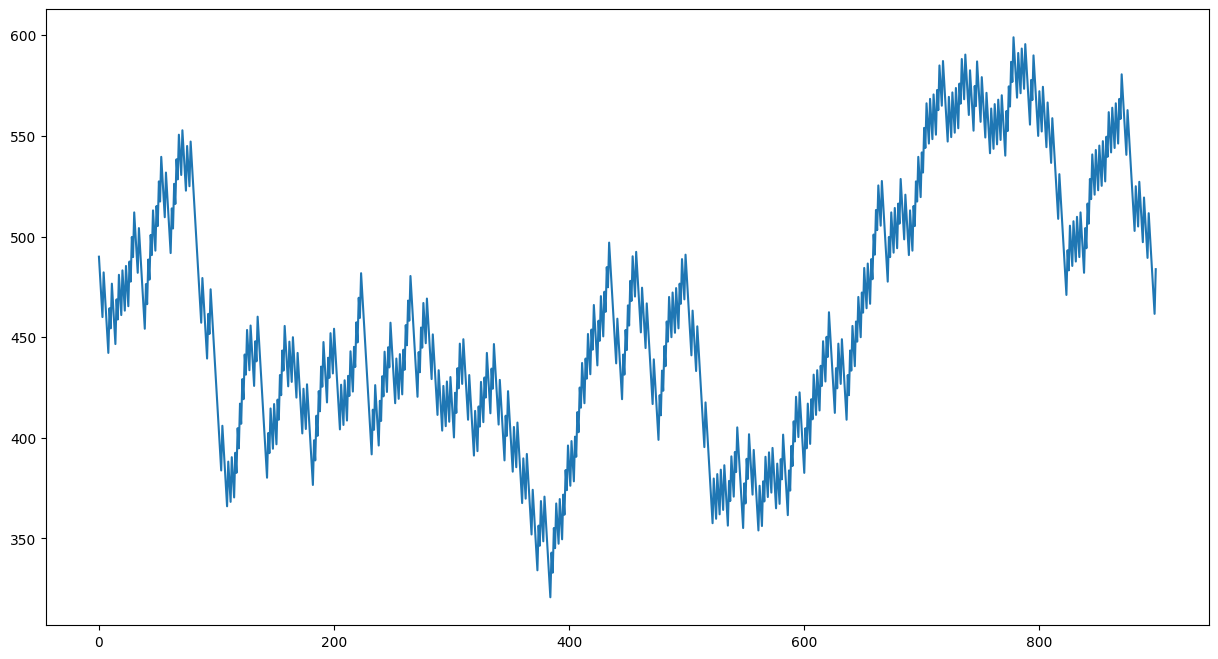

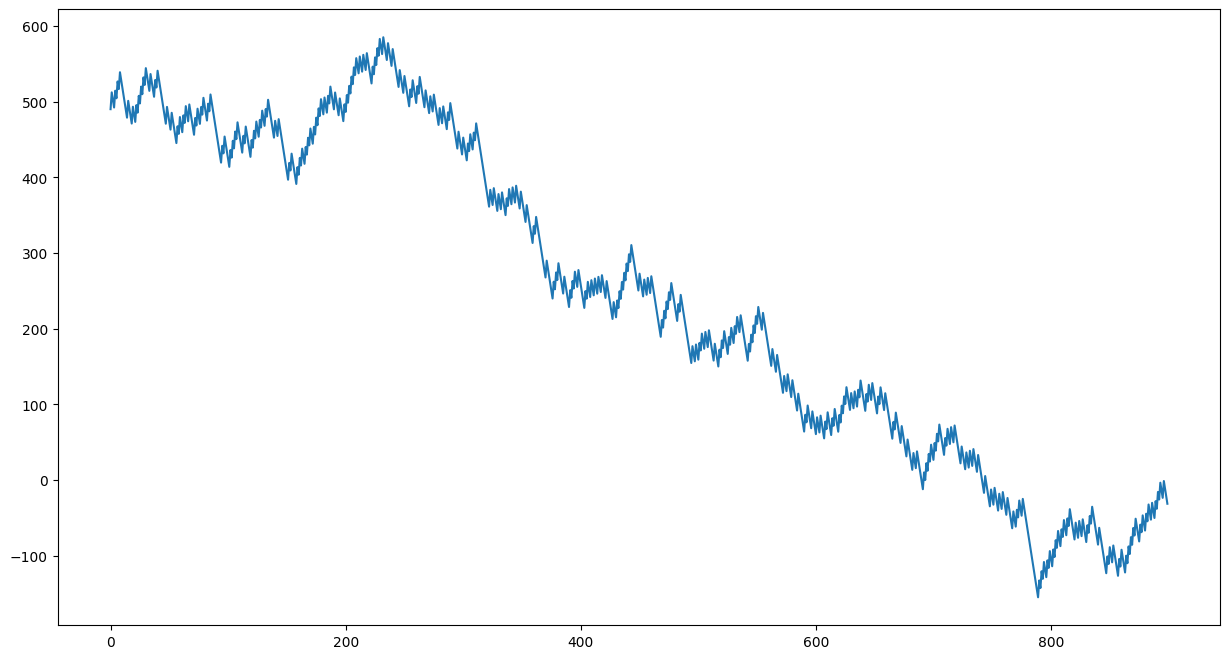

In [428]:
df = pd.read_csv('example.csv', sep=',', header=None)
#print(df.values)
df = df.T
num_plots = 10
j = np.arange(num_plots)
for k in j:
    fig, ax = plt.subplots(1,1,figsize=(15,8))
    ax.plot(t, df[k])
    plt.show()